This is the first project by Dean, Longhao and Senh. We start with a classical Titanic dataframe downloaded from Kaggle. https://www.kaggle.com/c/titanic

The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

In [318]:
#Start with importing data from local file
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
sns.set(style="ticks", color_codes=True)


In [319]:
titanic = pd.read_csv('train.csv')
titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [320]:
titanic.isna().mean().round(4) * 100

PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

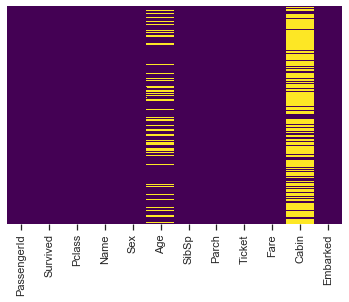

In [321]:
sns.heatmap(titanic.isnull(), yticklabels=False,cbar=False,cmap='viridis')

We first want to know the propotion of survival.

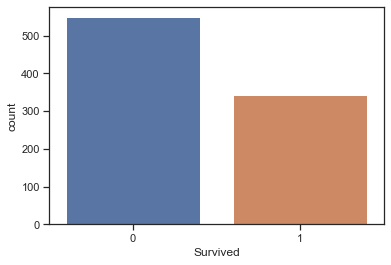

In [322]:
#We want to plot two bars with one bar representing survived and another one not survived
sns.countplot(x='Survived',data=titanic)

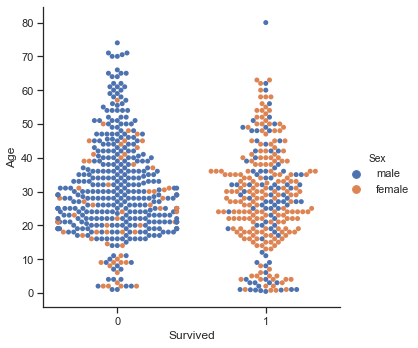

In [323]:
#
sns.catplot(x="Survived", y="Age", hue="Sex", kind="swarm", data=titanic)

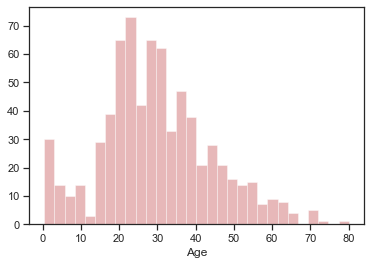

In [324]:
sns.distplot(titanic['Age'].dropna(),kde=False,bins=30,color='r')


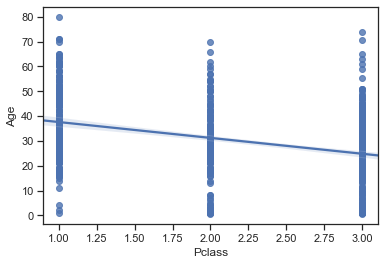

In [325]:
sns.regplot(x = 'Pclass',y = 'Age',data=titanic)

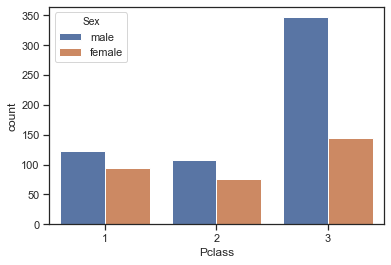

In [326]:
sns.countplot( x="Pclass", hue="Sex", data=titanic)

From this plot we can see that young passengers(children), high fare passengers are more likely to survive.

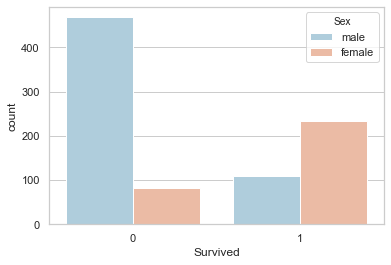

In [327]:
sns.set_style("whitegrid")
sns.countplot(x='Survived',hue="Sex",data=titanic,palette='RdBu_r')

In [328]:
#This function input the mean age for each class into the rows with NA age.
titanic.groupby('Pclass').Age.mean()

def input_age(col):
    age = col[0]
    pclass = col[1]
    if pd.isnull(age):
        if pclass == 1:
            return 38.23
        elif pclass == 2:
            return 29.8
        else:
            return 25
        
    else:
        return age
    
titanic['Age'] = titanic[['Age','Pclass']].apply(input_age,axis=1)


In [329]:
#Next, we want to drop cabin information
titanic.drop('Cabin',axis=1,inplace=True)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


A large group of 3rd class passengers did not survive.

Next step would be to do some feature engineering.

In [330]:
#Seperate children from adults
titanic.loc[titanic['Age'] <= 10, 'Children_Under_10'] = 1
titanic.loc[titanic['Age'] > 10, 'Children_Under_10'] = 0
#titanic['Children_Under_10'] = titanic['Age'].apply(lambda x: if x > 10, return "Adult")
titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Children_Under_10
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0.0


In [331]:
titanic['Male'] = pd.get_dummies(titanic["Sex"],drop_first=True)
embark = pd.get_dummies(titanic['Embarked'],drop_first=True)

titanic = pd.concat([titanic,embark],axis=1)

cols = ['Pclass','Male', 'Q','S','Fare','Children_Under_10','Age']


titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Children_Under_10,Male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0.0,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0.0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0.0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0.0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0.0,1,0,1


In [348]:
# Feature Extraction with RFE
from pandas import read_csv
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# load data
names = ['Pclass','Male', 'Q','S','Fare','Children_Under_10','Age','SibSp']

X = X_train
Y = y_train
# feature extraction
model = LogisticRegression(solver='lbfgs',max_iter=500)
rfe = RFE(model, 5)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 5
Selected Features: [ True  True False  True False  True False  True]
Feature Ranking: [1 1 2 1 4 1 3 1]


In [339]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

selected_cols = ['Pclass','Male', 'Q','S','Fare','Children_Under_10','Age','SibSp']
X=titanic[selected_cols]
y=titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)



model = LogisticRegression(max_iter=1000)

model.fit(X=X_train,y=y_train)
result=model.predict(X_test)


import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result2=logit_model.fit()
print(result2.summary2())
#X_train.dtypes

Optimization terminated successfully.
         Current function value: 0.440851
         Iterations 7
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.331     
Dependent Variable:  Survived         AIC:              541.4940  
Date:                2020-07-11 16:21 BIC:              576.6159  
No. Observations:    596              Log-Likelihood:   -262.75   
Df Model:            7                LL-Null:          -392.99   
Df Residuals:        588              LLR p-value:      1.6177e-52
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      7.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Pclass            -0.1018   0.1149  -0.8856 0.3759 -0.3270  0.1235
Male              -2.6572   0.2383 -11.1497 0.0000 -3

In [340]:
#Now let's predict the test.csv data and publish to kaggle
test_df = pd.read_csv("test.csv")

test_df['Age'] = test_df[['Age','Pclass']].apply(input_age,axis=1)

#Seperate children from adults
test_df.loc[test_df['Age'] <= 10, 'Children_Under_10'] = 1
test_df.loc[test_df['Age'] > 10, 'Children_Under_10'] = 0

test_df['Male'] = pd.get_dummies(test_df["Sex"],drop_first=True)
embark = pd.get_dummies(test_df['Embarked'],drop_first=True)

test_df = pd.concat([test_df,embark],axis=1)

result=model.predict(test_df.loc[:,selected_cols])

#print(result)

sample_df = pd.read_csv("gender_submission.csv")
del sample_df['Survived']
sample_df['Survived'] = result

#print(sample_df.head())

sample_df.to_csv('submission_cw.csv', index=False)

print(sample_df)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [341]:
#Evaluate the results
from sklearn.metrics import classification_report
print(classification_report(y_test,result))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       174
           1       0.76      0.66      0.71       121

    accuracy                           0.78       295
   macro avg       0.77      0.76      0.76       295
weighted avg       0.78      0.78      0.77       295



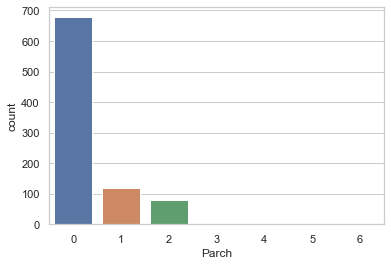

In [353]:
sns.countplot(x='Parch',data=titanic)
